In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        
        
    
    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            A[i,0]=1.5sig
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A,B,E =padding(7,1)

print(E)

(213, 213)
[[ 4.54008016e-01  4.54008016e-01  4.54008016e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.25751503e-01  1.25751503e-01  1.25751503e-01 ...  1.89629630e-03
   1.89629630e-03  1.89629630e-03]
 [ 3.67434870e-01  3.67434870e-01  3.67434870e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-7.69453253e-02 -7.69453253e-02 -7.69453253e-02 ...  4.52896508e-02
   4.52896508e-02  4.52896508e-02]
 [ 6.50601725e-01  6.50601725e-01  6.50601725e-01 ...  5.23952635e+00
   5.23952635e+00  5.23952635e+00]
 [ 1.27505558e-01  1.27505558e-01  1.27505558e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [7]:
lenA=[]
for i in range(1,2):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
maxlen=np.max(lenA)
print(maxlen)






213 1
213


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    pos= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    split_prob = pos.T[:,5]
    pos = pos.T[:,0:3]
    
    #print(b.shape,pos.shape)
    
    b=np.append(b,pos,axis=1)
    
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    #print(len(b[0]))
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    b=np.append(pos,split_prob,axis=1)
    
    
    print(b)
    b=np.repeat(b, 6, axis=1)
    #print(i)
    print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    padding(maxlen,run)
    

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 214 and the array at index 1 has size 213

python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

In [ ]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

<IPython.core.display.Javascript object>


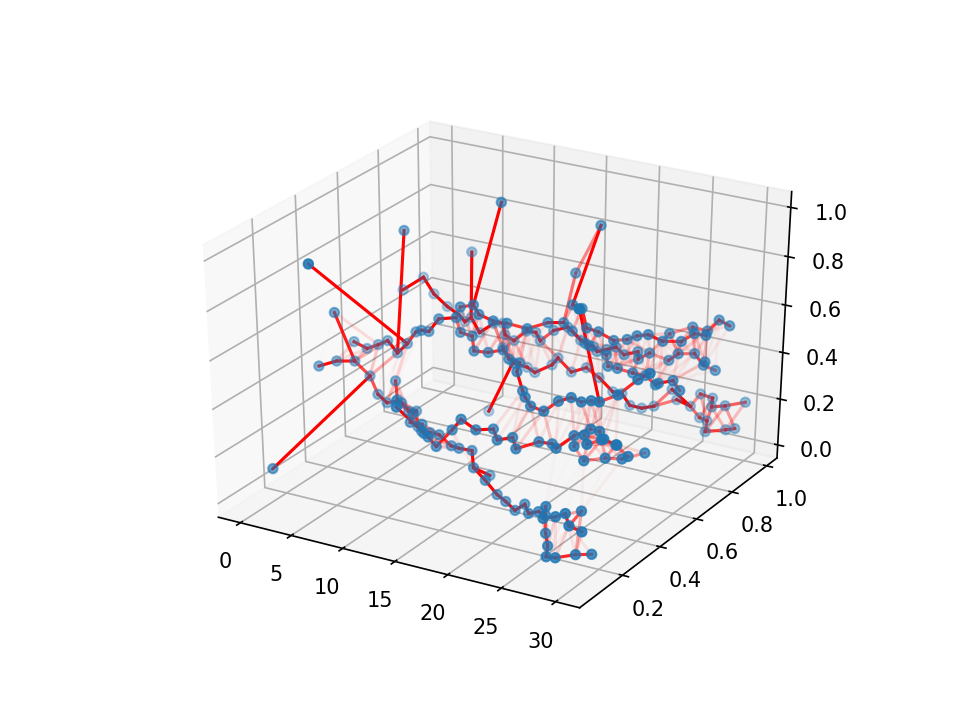

1.0 4.0
[0.39088176352705406, 0.37645729252484494]
1.0 6.0
[0.39088176352705406, 0.6072144288577154]
1.0 7.0
[0.39088176352705406, 0.40211928098157185]
2.0 4.0
[0.40350701402805605, 0.37645729252484494]
2.0 7.0
[0.40350701402805605, 0.40211928098157185]
3.0 5.0
[0.49729458917835667, 0.5333703369265879]
4.0 9.0
[0.37645729252484494, 0.3995642342633117]
4.0 10.0
[0.37645729252484494, 0.3910955769334335]
5.0 11.0
[0.5333703369265879, 0.4706700653555784]
6.0 9.0
[0.6072144288577154, 0.3995642342633117]
6.0 10.0
[0.6072144288577154, 0.3910955769334335]
7.0 9.0
[0.40211928098157185, 0.3995642342633117]
7.0 10.0
[0.40211928098157185, 0.3910955769334335]
8.0 12.0
[0.156312625250501, 0.32502894389019554]
9.0 12.0
[0.3995642342633117, 0.32502894389019554]
9.0 14.0
[0.3995642342633117, 0.42747757348941623]
10.0 12.0
[0.3910955769334335, 0.32502894389019554]
10.0 14.0
[0.3910955769334335, 0.42747757348941623]
11.0 13.0
[0.4706700653555784, 0.4167570490736632]
12.0 17.0
[0.32502894389019554, 0.3864

157.0 173.0
[0.5053063096385837, 0.31850124539063007]
157.0 174.0
[0.5053063096385837, 0.42473860252038254]
158.0 163.0
[0.6196047274367547, 0.49287567958317724]
158.0 165.0
[0.6196047274367547, 0.4273704821375906]
158.0 170.0
[0.6196047274367547, 0.591250327231706]
158.0 171.0
[0.6196047274367547, 0.5645207461138766]
159.0 164.0
[0.10374583983804189, 0.10977842413182366]
159.0 169.0
[0.10374583983804189, 0.19337852077502318]
160.0 168.0
[0.36508934617066546, 0.39507045730262075]
160.0 172.0
[0.36508934617066546, 0.5188970576316432]
160.0 173.0
[0.36508934617066546, 0.31850124539063007]
160.0 174.0
[0.36508934617066546, 0.42473860252038254]
161.0 164.0
[0.20694784390694435, 0.10977842413182366]
161.0 169.0
[0.20694784390694435, 0.19337852077502318]
162.0 166.0
[0.15395926290662895, 0.1674841236582345]
162.0 167.0
[0.15395926290662895, 0.026643699671931448]
162.0 173.0
[0.15395926290662895, 0.31850124539063007]
163.0 175.0
[0.49287567958317724, 0.5454991614114971]
163.0 179.0
[0.4928756

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')

run=1

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)

x=x[1:]
y=y[1:]
t=t[1:]


#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

In [ ]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(31):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)